# **DATA AUGMENTATION**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
 'tf_flowers',
 split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
 with_info=True,
 as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


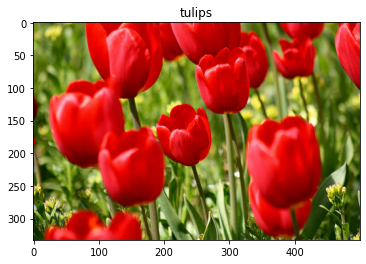

In [4]:
get_label_name = metadata.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

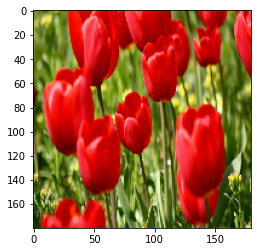

In [5]:
IMG_SIZE = 180
resize_and_rescale = tf.keras.Sequential([
 layers.Resizing(IMG_SIZE, IMG_SIZE),
 layers.Rescaling(1./255)
])
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [6]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


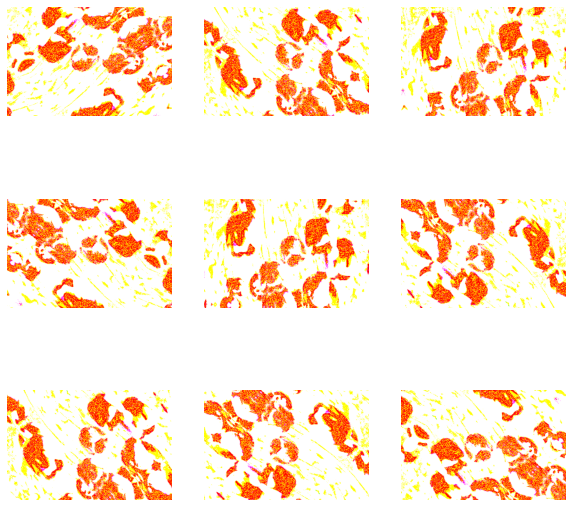

In [7]:
data_augmentation = tf.keras.Sequential([
 layers.RandomFlip("horizontal_and_vertical"),
 layers.RandomRotation(0.2),
])
# Add the image to a batch.
image = tf.expand_dims(image, 0)
plt.figure(figsize=(10, 10))
for i in range(9):
 augmented_image = data_augmentation(image)
 ax = plt.subplot(3, 3, i + 1)
 plt.imshow(augmented_image[0])
 plt.axis("off")

In [8]:
model = tf.keras.Sequential([
 # Add the preprocessing layers you created earlier.
 resize_and_rescale,
 data_augmentation,
 layers.Conv2D(16, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 # Rest of your model.
])
aug_ds = train_ds.map(
 lambda x, y: (resize_and_rescale(x, training=True), y))
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, shuffle=False, augment=False):
 # Resize and rescale all datasets.
 ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
 num_parallel_calls=AUTOTUNE)
 if shuffle:
   ds = ds.shuffle(1000)
 # Batch all datasets.
 ds = ds.batch(batch_size)
  # Use data augmentation only on the training set.
 if augment:
   ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
 # Use buffered prefetching on all datasets.
 return ds.prefetch(buffer_size=AUTOTUNE)
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)
model = tf.keras.Sequential([
 layers.Conv2D(16, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(32, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(64, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Flatten(),
 layers.Dense(128, activation='relu'),
 layers.Dense(num_classes)
])
model.compile(optimizer='adam',
 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
 metrics=['accuracy'])
epochs=5
history = model.fit(
 train_ds,
 validation_data=val_ds,
 epochs=epochs
)

Epoch 1/5
57/92 [=================>............] - ETA: 44s - loss: 1.3717 - accuracy: 0.3854

KeyboardInterrupt: ignored

In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

In [ ]:
def random_invert_img(x, p=0.5):
 if tf.random.uniform([]) < p:
   x = (255-x)
 else:
   x
   return x
def random_invert(factor=0.5):
 return layers.Lambda(lambda x: random_invert_img(x, factor))
random_invert = random_invert()
plt.figure(figsize=(10, 10))
for i in range(9):
 augmented_image = random_invert(image)
 ax = plt.subplot(3, 3, i + 1)
plt.imshow(augmented_image[0].numpy().astype("uint8"))
plt.axis("off")

In [ ]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor
  def call(self, x):
    return random_invert_img(x)
    _ = plt.imshow(RandomInvert()(image)[0])
    (train_ds, val_ds, test_ds), metadata = tfds.load('tf_flowers',split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], with_info=True, as_supervised=True,)
    image, label = next(iter(train_ds))
    _ = plt.imshow(image)
    _ = plt.title(get_label_name(label))

In [ ]:
def visualize(original, augmented):
 fig = plt.figure()
 plt.subplot(1,2,1)
 plt.title('Original image')
 plt.imshow(original)
 plt.subplot(1,2,2)
 plt.title('Augmented image')
 plt.imshow(augmented)
 flipped = tf.image.flip_left_right(image)
 visualize(image, flipped)

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)